In [98]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [296]:
from fastai.imports import *
from fastai.structured import * 
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn.linear_model import LogisticRegression
# from collections import Counter
# from sklearn.linear_model import LogisticRegression
from statistics import *
from sklearn.model_selection import StratifiedKFold
# from sklearn import metrics
import feather
import seaborn as sns
from collections import Counter
# from sklearn.model_selection import
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,classification_report,confusion_matrix
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.feature_selection import RFE, f_regression
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit

In [297]:
df = pd.read_csv("D:/Kaggle/WNS/train.csv",low_memory=False,parse_dates=['impression_time'])
df_test = pd.read_csv("D:/Kaggle/WNS/test.csv",low_memory=False,parse_dates=['impression_time'])

In [298]:
df.is_click.value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


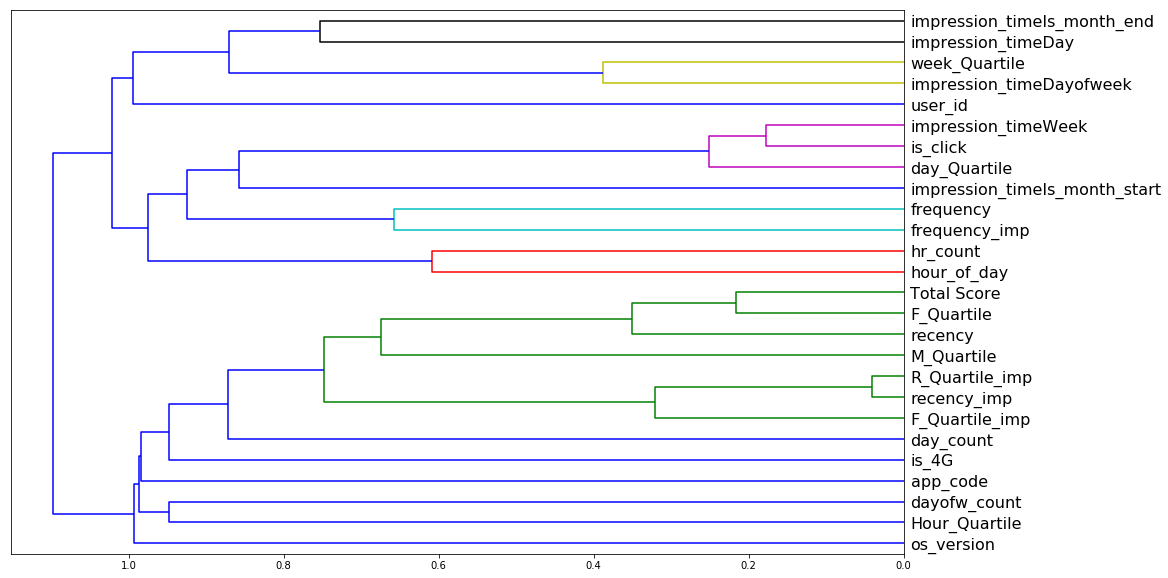

In [299]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_corr).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_corr.columns, orientation='left', leaf_font_size=16)
plt.show()

In [300]:
df_rfm = df.append(df_test) 

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Here we finally create a model with all the analysis done using XGBoost and TimeSeriesSplit

In [301]:
df_rfm['hour_of_day'] = df_rfm.impression_time.apply(lambda x: x.hour)

In [302]:
df_rfm.shape

(328284, 8)

In [303]:
import datetime as dt
sd = dt.datetime(2018,12,18)
df_rfm['hist_imp']=sd - df_rfm['impression_time']
df_rfm['hist_imp'].astype('timedelta64[D]')
df_rfm['hist_imp']=df_rfm['hist_imp'] / np.timedelta64(1, 'D')

In [304]:
rfmTable = df_rfm.groupby('user_id').agg({'hist_imp': lambda x:x.min(), # Recency
                                        'user_id': lambda x: len(x)})          # Monetary Value

rfmTable.rename(columns={'hist_imp': 'recency_imp', 
                         'user_id': 'frequency_imp'}, inplace=True)

In [305]:
hrcount = df_rfm.groupby('hour_of_day').agg({'hour_of_day':lambda x:len(x)})
hrcount.rename(columns={'hour_of_day':'hr_count'},inplace=True)
hrcount = hrcount
quartiles1 = hrcount.quantile(q=[0.25,0.50,0.75])
quartiles1=quartiles1.to_dict()
hrcount['Hour_Quartile'] = hrcount['hr_count'].apply(FMClass, args=('hr_count',quartiles1,))

In [306]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

      recency_imp  frequency_imp
0.25     2.312500            1.0
0.50    10.034722            2.0
0.75    19.828472            4.0 <class 'pandas.core.frame.DataFrame'>


In [307]:
quartiles=quartiles.to_dict()
quartiles

{'recency_imp': {0.25: 2.3125,
  0.5: 10.034722222222221,
  0.75: 19.82847222222222},
 'frequency_imp': {0.25: 1.0, 0.5: 2.0, 0.75: 4.0}}

In [308]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1   

In [309]:
rfmSeg = rfmTable
rfmSeg['R_Quartile_imp'] = rfmSeg['recency_imp'].apply(RClass, args=('recency_imp',quartiles,))
rfmSeg['F_Quartile_imp'] = rfmSeg['frequency_imp'].apply(FMClass, args=('frequency_imp',quartiles,))

In [310]:
rfmSeg['RFMClass_imp'] = rfmSeg.R_Quartile_imp.map(str) \
                            + rfmSeg.F_Quartile_imp.map(str) \

In [311]:
rfmSeg['Total_Score_imp'] = rfmSeg['R_Quartile_imp'] + rfmSeg['F_Quartile_imp']
print(rfmSeg.head(), rfmSeg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89157 entries, 0 to 92586
Data columns (total 6 columns):
recency_imp        89157 non-null float64
frequency_imp      89157 non-null int64
R_Quartile_imp     89157 non-null int64
F_Quartile_imp     89157 non-null int64
RFMClass_imp       89157 non-null object
Total_Score_imp    89157 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 4.8+ MB
         recency_imp  frequency_imp  R_Quartile_imp  F_Quartile_imp  \
user_id                                                               
0          21.020833              1               4               4   
1           4.174306              1               2               4   
2          26.092361              4               4               2   
3          12.091667              1               3               4   
4           2.599306              2               2               3   

        RFMClass_imp  Total_Score_imp  
user_id                                
0        

In [312]:
RFM = rfmSeg.reset_index()

In [313]:
hrcount = hrcount.reset_index()

In [314]:
RFM.to_feather('tmp/RFM_imp')

In [315]:
RFM.head()

,user_id,recency_imp,frequency_imp,R_Quartile_imp,F_Quartile_imp,RFMClass_imp,Total_Score_imp
0,0,21.020833,1,4,4,44,8
1,1,4.174306,1,2,4,24,6
2,2,26.092361,4,4,2,42,6
3,3,12.091667,1,3,4,34,7
4,4,2.599306,2,2,3,23,5


In [316]:
RFM_logs = feather.read_dataframe('tmp/RFM')

In [317]:
RFM_logs.head()

,user_id,recency,frequency,monetary_value_avg,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
0,0,4.144444,42,9395.666667,2,2,2,222,6
1,1,2.932639,8,3946.750000,2,3,4,234,9
2,2,2.188889,165,14809.509091,2,1,1,211,4
3,3,53.331250,8,7257.375000,4,3,3,433,10
4,4,4.027778,2,30114.500000,2,4,1,241,7


In [318]:
df_raw = pd.merge(df_rfm,RFM,how='left',on='user_id')

In [319]:
df_raw.drop('hist_imp',axis=1,inplace=True)

In [320]:
df_raw = pd.merge(df_raw,RFM_logs,how='left',on='user_id')

In [321]:
df_raw = pd.merge(df_raw,hrcount,how='left',on='hour_of_day')

In [322]:
add_datepart(df_raw,'impression_time')

In [323]:
df_raw.head().T

,0,1,2,3,4
app_code,422,467,259,244,473
impression_id,c4ca4238a0b923820dcc509a6f75849b,45c48cce2e2d7fbdea1afc51c7c6ad26,70efdf2ec9b086079795c442636b55fb,8e296a067a37563370ded05f5a3bf3ec,182be0c5cdcd5072bb1864cdee4d3d6e
is_4G,0,1,1,1,0
is_click,0,1,0,0,0
os_version,old,latest,intermediate,latest,latest
user_id,87862,63410,71748,69209,62873
hour_of_day,0,0,0,0,0
recency_imp,31.2715,0.704167,1.64514,25.9021,22.0507
frequency_imp,3,61,13,4,16
R_Quartile_imp,4,1,1,4,4


In [324]:
df_raw.drop(['impression_timeDayofyear','impression_timeMonth','impression_timeYear','impression_timeIs_quarter_end','impression_timeIs_quarter_start','impression_timeIs_year_start','impression_timeIs_year_end','impression_timeElapsed',
             'impression_id','RFMClass','monetary_value_avg',
             'RFMClass_imp','Total_Score_imp','R_Quartile'],axis=1,inplace=True)

In [325]:
weekcount = df_raw.groupby('impression_timeDayofweek').agg({'impression_timeDayofweek':lambda x:len(x)})
weekcount.rename(columns={'impression_timeDayofweek':'dayofw_count'},inplace=True)
daycount = df_raw.groupby('impression_timeDay').agg({'impression_timeDay':lambda x:len(x)})
daycount.rename(columns={'impression_timeDay':'day_count'},inplace=True)

In [326]:
quartiles2 = weekcount.quantile(q=[0.25,0.50,0.75])
quartiles2=quartiles2.to_dict()
weekcount['week_Quartile'] = weekcount['dayofw_count'].apply(FMClass, args=('dayofw_count',quartiles2,))
quartiles3 = daycount.quantile(q=[0.25,0.50,0.75])
quartiles3=quartiles3.to_dict()
daycount['day_Quartile'] = daycount['day_count'].apply(FMClass, args=('day_count',quartiles3,))

In [327]:
weekcount = weekcount.reset_index()
daycount = daycount.reset_index()

In [328]:
df_raw = pd.merge(df_raw,weekcount,how='left',on='impression_timeDayofweek')
df_raw = pd.merge(df_raw,daycount,how='left',on ='impression_timeDay')

In [329]:
df_neg = df_raw.ix[df_raw.is_click==0][:10862]
df_pos = df_raw.ix[df_raw.is_click==1]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [330]:
df_corr = pd.concat([df_pos,df_neg])

In [331]:
df_test1 = df_raw.iloc[-90675:]

In [332]:
df_valid = df_raw.iloc[233487:237609]

In [333]:
df_valid = df_valid.reset_index()

In [334]:
df_test1 = df_test1.reset_index()

In [335]:
df_test1.drop('index',axis=1,inplace=True)
df_valid.drop('index',axis=1,inplace=True)

In [336]:
df_raw = df_raw.iloc[0:233487]

In [337]:
df_raw = df_raw.reset_index()
df_raw.drop('index',axis=1,inplace=True)

In [338]:
df_raw.head().T

,0,1,2,3,4
app_code,422,467,259,244,473
is_4G,0,1,1,1,0
is_click,0,1,0,0,0
os_version,old,latest,intermediate,latest,latest
user_id,87862,63410,71748,69209,62873
hour_of_day,0,0,0,0,0
recency_imp,31.2715,0.704167,1.64514,25.9021,22.0507
frequency_imp,3,61,13,4,16
R_Quartile_imp,4,1,1,4,4
F_Quartile_imp,2,1,1,2,1


In [339]:
train_cats(df_test1)
df_test1.os_version.cat.set_categories(['latest','intermediate','old'],ordered=True,inplace=True)
df_test1.os_version  = df_test1.os_version.cat.codes
train_cats(df_raw)
df_raw.os_version.cat.set_categories(['latest','intermediate','old'],ordered=True,inplace=True)
df_raw.os_version  = df_raw.os_version.cat.codes
train_cats(df_valid)
df_valid.os_version.cat.set_categories(['latest','intermediate','old'],ordered=True,inplace=True)
df_valid.os_version  = df_valid.os_version.cat.codes


In [340]:
df_raw,y,nas = proc_df(df_raw,'is_click')
df_test1,y,nas = proc_df(df_test1,'is_click')
df_valid,y,nas = proc_df(df_valid,'is_click')

In [341]:
df_test1.drop(['recency_na','frequency_na',"F_Quartile_na","M_Quartile_na",
               'Total Score_na'],axis=1,inplace=True)
df_raw.drop(['recency_na','frequency_na',"F_Quartile_na","M_Quartile_na",
               'Total Score_na',],axis=1,inplace=True)


In [342]:
df_valid.head().T

,0,1,2,3,4
app_code,291,190,317,371,190
is_4G,0,0,1,0,0
os_version,0,0,0,0,1
user_id,51409,40729,29873,30267,87021
hour_of_day,0,0,0,0,0
recency_imp,0.970139,3.27708,5.99028,-0.00902778,5.99931
frequency_imp,18,14,8,33,1
R_Quartile_imp,1,2,2,1,2
F_Quartile_imp,1,1,1,1,4
recency,0.170139,0.0868056,2.19931,0.154167,0.126389


In [280]:
# df_valid.drop(['hr_count','day_count'],axis=1,inplace=True)
# df_test1.drop(['hr_count','day_count'],axis=1,inplace=True)
# df_raw.drop(['hr_count','day_count'],axis=1,inplace=True)

In [57]:
# df_valid.drop(['dayofw_count'],axis=1,inplace=True)
# df_test1.drop(['dayofw_count'],axis=1,inplace=True)
# df_raw.drop(['dayofw_count'],axis=1,inplace=True)

In [58]:
# df_valid.drop(['week_Quartile'],axis=1,inplace=True)
# df_test1.drop(['week_Quartile'],axis=1,inplace=True)
# df_raw.drop(['week_Quartile'],axis=1,inplace=True)

In [343]:
df_valid.drop('user_id',axis=1,inplace=True)
df_raw.drop('user_id',axis=1,inplace=True)
df_test1.drop('user_id',axis=1,inplace=True)

In [359]:
df_test1.head()

,app_code,is_4G,os_version,hour_of_day,recency_imp,frequency_imp,recency,frequency,Hour_Quartile,impression_timeDay,impression_timeDayofweek,impression_timeIs_month_end,impression_timeIs_month_start
0,127,1,0,7,-0.735417,10,0.207639,1.0,4,13,3,False,False
1,44,0,0,7,-0.243056,9,0.362500,72.0,4,13,3,False,False
2,296,1,0,7,3.495139,2,5.030556,9.0,4,13,3,False,False
3,207,1,0,7,-0.499306,13,1.682639,37.0,4,13,3,False,False
4,242,1,0,7,-0.797222,23,4.127778,28.0,4,13,3,False,False


In [147]:
X_train.head().T

,0,1,2,3,4
app_code,422,467,259,244,473
is_4G,0,1,1,1,0
os_version,2,0,1,0,0
hour_of_day,0,0,0,0,0
recency_imp,31.2715,0.704167,1.64514,25.9021,22.0507
frequency_imp,3,61,13,4,16
R_Quartile_imp,4,1,1,4,4
F_Quartile_imp,2,1,1,2,1
recency,53.2424,1.16458,18.5,18.3062,0.0444444
frequency,1,12,2,18,46


Using VIF to deal with Multicollinearity and Outliers now best thing is keep data with variance less than 10 but the thing is multicollinearity always doesnt affect the data highly
so VIF works sometimes sometimes you need that multicollinearity

In [153]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)
    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [295]:
transformer = ReduceVIF()

# Only use 10 columns for speed in this example
X = transformer.fit_transform(X_train, y_train)

X.head()


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


ReduceVIF fit
ReduceVIF transform
Dropping impression_timeWeek with vif=758.0955827522541
Dropping Total Score with vif=160.0344834375674
Dropping dayofw_count with vif=144.01001259660376
Dropping R_Quartile_imp with vif=61.098290573024684
Dropping hr_count with vif=25.880905873589466
Dropping day_count with vif=12.551716547846306
Dropping week_Quartile with vif=9.83590926599152
Dropping F_Quartile with vif=9.08674498967677
Dropping F_Quartile_imp with vif=6.710657007995088
Dropping day_Quartile with vif=5.813079376146898
Dropping M_Quartile with vif=5.430096564109836


,app_code,is_4G,os_version,hour_of_day,recency_imp,frequency_imp,recency,frequency,Hour_Quartile,impression_timeDay,impression_timeDayofweek,impression_timeIs_month_end,impression_timeIs_month_start
0,422.0,0.0,2.0,0.0,31.271528,3.0,53.242361,1.0,1.0,15.0,3.0,0.0,0.0
1,467.0,1.0,0.0,0.0,0.704167,61.0,1.164583,12.0,1.0,15.0,3.0,0.0,0.0
2,259.0,1.0,1.0,0.0,1.645139,13.0,18.500000,2.0,1.0,15.0,3.0,0.0,0.0
3,244.0,1.0,0.0,0.0,25.902083,4.0,18.306250,18.0,1.0,15.0,3.0,0.0,0.0
4,473.0,0.0,0.0,0.0,22.050694,16.0,0.044444,46.0,1.0,15.0,3.0,0.0,0.0


In [156]:
X.impression_timeIs_month_end.value_counts()

0.0    223594
1.0      9893
Name: impression_timeIs_month_end, dtype: int64

In [345]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = m.predict_proba(X_t)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, roc_auc_score

In [346]:
y_train = df['is_click'][0:233487]

In [347]:
y_valid = df['is_click'][-4122:]

In [151]:
# df_raw.drop('is_click')

In [348]:
df_valid.drop(['impression_timeWeek','Total Score','dayofw_count','R_Quartile_imp','hr_count','day_count','week_Quartile',
               'F_Quartile','F_Quartile_imp','day_Quartile','M_Quartile' ],axis=1,inplace=True)

In [152]:
X_train = df_raw

In [177]:
# Smote = ADASYN(random_state=8)
# X_train_resampled,y_train_resampled = Smote.fit_resample(X,y_train)

In [187]:
X['is_clicktr'] = df_stack1['is_clicktr'] 

In [211]:
# X.drop(['Hour_Quartile'],axis=1,inplace=True)
# df_valid.drop(['Hour_Quartile'],axis=1,inplace=True)

In [349]:
m = XGBClassifier(n_estimators=550,subsample=0.8,colsample_bytree=0.2,
                  learning_rate=0.05,max_depth=10,gamma=0.1,min_child_weight=1,
                  nthread=4,scale_pos_weight=1,seed=8)
# m.fit(X,y_train)

In [218]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [217]:
rfe = RFE(m,n_features_to_select=1, verbose =3 )
rfe.fit(X,y_train)


Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


NameError: name 'ranking' is not defined

In [222]:
ranks = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

In [223]:
ranks

{'app_code': 0.83,
 'is_4G': 0.17,
 'os_version': 0.25,
 'hour_of_day': 0.5,
 'recency_imp': 0.92,
 'frequency_imp': 0.67,
 'recency': 1.0,
 'frequency': 0.75,
 'Hour_Quartile': 0.33,
 'impression_timeDay': 0.58,
 'impression_timeDayofweek': 0.42,
 'impression_timeIs_month_end': 0.08,
 'impression_timeIs_month_start': 0.0}

In [233]:
df_valid.head()

,app_code,is_4G,os_version,hour_of_day,recency,frequency,impression_timeDay,impression_timeDayofweek,impression_timeIs_month_start
0,291,0,0,0,0.170139,14.0,12,2,False
1,190,0,0,0,0.086806,50.0,12,2,False
2,317,1,0,0,2.199306,3.0,12,2,False
3,371,0,0,0,0.154167,216.0,12,2,False
4,190,0,1,0,0.126389,11.0,12,2,False


Final result with TimeSeries Split was very promising 

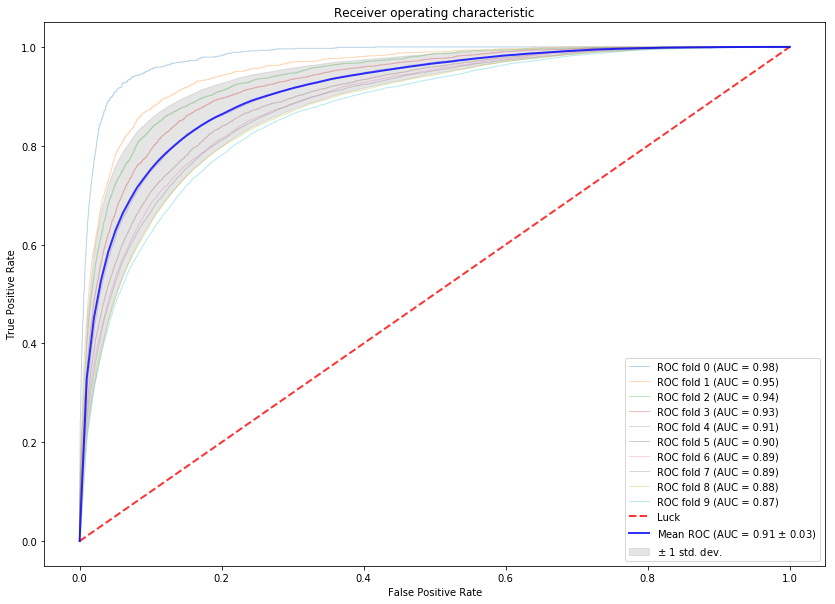

,AUC Train,AUC Test
0,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
1,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
2,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
3,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
4,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
5,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
6,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
7,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
8,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>
9,<function roc_auc_score at 0x000000F9A1345488>,<function roc_auc_score at 0x000000F9A1345488>


In [365]:
cv = TimeSeriesSplit(n_splits=10,max_train_size=None)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X,y_train), range(10)):
    
    X_t = X.iloc[train].values
    y = y_train.iloc[train].values
#     Smote = ADASYN(random_state=8)
#     X_train_resampled,y_train_resampled = Smote.fit_resample(X,y)
    m.fit(X_t, y)
    _, _, auc_score_train = compute_roc_auc(test)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [182]:
y_preds_1 = m.predict_proba(X)[:,1]
dic = {'is_clicktr':y_preds_1}
df_stack1 = pd.DataFrame(data=dic)

0.7159907362455921


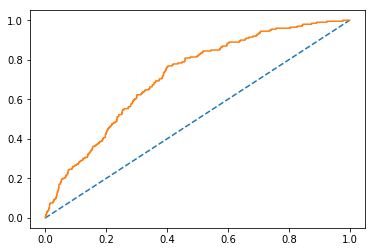

In [366]:
y_preds = m.predict_proba(df_valid.values)[:,1]
print(roc_auc_score(y_valid,y_preds))
fpr, tpr, thresholds = roc_curve(y_valid, y_preds)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr)
# show the plot
pyplot.show()

In [181]:
dic = {'is_clicktr':y_preds}
df_stack = pd.DataFrame(data=dic)

In [189]:
df_valid['is_clicktr'] = df_stack['is_clicktr']

In [ ]:
# Smote = ADASYN(random_state=8)

# Smote = ADASYN(random_state=8)


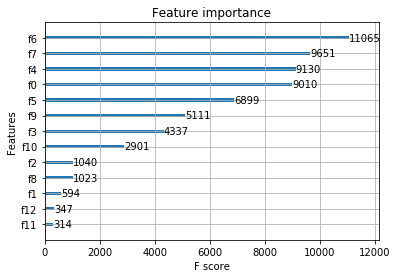

In [165]:
plot_importance(m)

In [367]:
df_test1.drop(['impression_timeWeek','Total Score','dayofw_count','R_Quartile_imp','hr_count','day_count','week_Quartile',
               'F_Quartile','F_Quartile_imp','day_Quartile','M_Quartile' ],axis=1,inplace=True)

KeyError: "['impression_timeWeek' 'Total Score' 'dayofw_count' 'R_Quartile_imp' 'hr_count' 'day_count' 'week_Quartile'\n 'F_Quartile' 'F_Quartile_imp' 'day_Quartile' 'M_Quartile'] not found in axis"

In [356]:
# df_test1.drop(['impression_timeIs_month_end','impression_timeIs_month_end'],inplace=True,axis=1)

In [368]:
y_preds_test = m.predict_proba(df_test1.values)[:,1]

In [369]:
dic = {'is_click':y_preds_test}
df_sub = pd.DataFrame(data=dic)

In [370]:
df_sub = pd.concat([df_test["impression_id"],df_sub],axis=1)

In [371]:
df_sub.shape

(90675, 2)

In [372]:
df_sub.to_csv("D:/Kaggle/WNS/sub_test.csv",index=False)

In [373]:
df_sub.is_click.value_counts()

0.091262    5
0.023302    4
0.050301    4
0.044829    4
0.104068    4
0.097433    4
0.047908    4
0.276177    4
0.166614    4
0.130085    4
0.035902    4
0.033761    4
0.075982    4
0.015937    4
0.117746    4
0.054585    4
0.012764    4
0.040896    4
0.283450    4
0.028260    4
0.006542    4
0.020591    4
0.005807    4
0.051553    4
0.028671    4
0.017542    4
0.014104    4
0.097474    4
0.017020    4
0.116628    4
           ..
0.014745    1
0.014903    1
0.051798    1
0.059611    1
0.072346    1
0.029805    1
0.032912    1
0.059610    1
0.144690    1
0.036173    1
0.015542    1
0.083027    1
0.036172    1
0.018086    1
0.009042    1
0.012949    1
0.007451    1
0.053303    1
0.006475    1
0.014902    1
0.018085    1
0.018085    1
0.134229    1
0.001130    1
0.059520    1
0.025898    1
0.023603    1
0.038774    1
0.043983    1
0.058527    1
Name: is_click, Length: 77715, dtype: int64

I learned a lot during this competition I was Rank 100 on Public LeaderBoard and 142 on Private, thats still top 5% which is decent
I used Stratified Kfold as CV strategy thats why i Overfit a LittleBit but TimeSeriesSplit should have been the choice